In [52]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from copy import deepcopy

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.bpr import BayesianPersonalizedRanking

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

import catboost
from catboost import CatBoostClassifier, CatBoostRanker, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

from lightgbm import LGBMClassifier, LGBMRanker

import optuna
from optuna.samplers import TPESampler

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    return precision

def ap_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(recommended_list, bought_list)
    
    if sum(flags) == 0:
        return 0
    
    sum_ = 0
    for i in range(k):
        
        if flags[i]:
            p_k = precision_at_k(recommended_list, bought_list, k=i+1)
            sum_ += p_k
            
    result = sum_ / sum(flags)
    
    return result

def map_k(recommend_list, bought_list, k=5):
    return np.mean([ap_k(rec, bt, k) for rec, bt in zip(recommend_list, bought_list)])

def recall_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    flags = np.isin(bought_list, recommended_list)
    
    recall = flags.sum() / len(bought_list)
    
    return recall

def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    return df

def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [3]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')
test = pd.read_csv('test_users.csv')
test1 = pd.read_csv('retail_test1.csv')

N_preds = 30

In [4]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


##### Dealing with implicit data as users do not rate bought products at any way.

In [4]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [1169]:
user_features.user_id.nunique(), item_features.item_id.nunique()

(801, 92353)

In [5]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1 = reduce_memory(data_train_lvl_1)
data_val_lvl_1 = reduce_memory(data_val_lvl_1)
data_train_lvl_2 = reduce_memory(data_train_lvl_2)
data_val_lvl_2 = reduce_memory(data_val_lvl_2)

print(f'Level 1 Train - users: {data_train_lvl_1.user_id.nunique()}, items: {data_train_lvl_1.item_id.nunique()}')
print(f'Level 1 Valid - users: {data_val_lvl_1.user_id.nunique()}, items: {data_val_lvl_1.item_id.nunique()}')
print(f'Level 2 Train - users: {data_train_lvl_2.user_id.nunique()}, items: {data_train_lvl_2.item_id.nunique()}')
print(f'Level 2 Valid - users: {data_val_lvl_2.user_id.nunique()}, items: {data_val_lvl_2.item_id.nunique()}')

Level 1 Train - users: 2498, items: 83685
Level 1 Valid - users: 2154, items: 27649
Level 2 Train - users: 2154, items: 27649
Level 2 Valid - users: 2042, items: 24329


In [ ]:
# ищем общих пользователей
# common_users = list(set(data_train_lvl_1.user_id.values)&(set(data_val_lvl_1.user_id.values))&set(data_val_lvl_2.user_id.values))

# оставляем общих пользователей
# data_train_lvl_1 = data_train_lvl_1[data_train_lvl_1.user_id.isin(common_users)]
# data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
# data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
# data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

# print(f'Level 1 Train - users: {data_train_lvl_1.user_id.nunique()}, items: {data_train_lvl_1.item_id.nunique()}')
# print(f'Level 1 Valid - users: {data_val_lvl_1.user_id.nunique()}, items: {data_val_lvl_1.item_id.nunique()}')
# print(f'Level 2 Train - users: {data_train_lvl_2.user_id.nunique()}, items: {data_train_lvl_2.item_id.nunique()}')
# print(f'Level 2 Valid - users: {data_val_lvl_2.user_id.nunique()}, items: {data_val_lvl_2.item_id.nunique()}')

In [6]:
result = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

final = test1.groupby('user_id')['item_id'].unique().reset_index()
final = final.rename(columns={'item_id': 'actual'})

In [7]:
# top 5 popular recommendations
popular_recs = popularity_recommendation(data_train_lvl_1, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

,user_id,actual,popular_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[6534178, 6533889, 1029743, 6534166, 1082185]"


In [55]:
def prefilter_items(data, take_n_popular=5000, item_features=None, n_weeks=52):
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

    top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]

    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]

    # Уберем не интересные для рекоммендаций категории (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features.groupby('department')['item_id'].nunique().sort_values(ascending=False)).reset_index()
        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        data = data[~data['item_id'].isin(items_in_rare_departments)]

    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data[data['price'] > 2]

    # Уберем слишком дорогие товарыs
    data = data[data['price'] < 50]

    # уберем товары, не продававшиеся более n_week недель
    data = data[data['week_no'] >= data['week_no'].max() - n_weeks]

    # Возьмем топ по популярности
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()
    
    # Заведем фиктивный item_id (если юзер покупал товары из топ-N, то он "купил" такой товар)
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999
    
    return data

def postfilter(recommendations, item_info, N=5):
    """Пост-фильтрация товаров
    
    Input
    -----
    recommendations: list
        Ранжированный список item_id для рекомендаций
    item_info: pd.DataFrame
        Датафрейм с информацией о товарах
    """
    
    # Уникальность
    unique_recommendations = []
    [unique_recommendations.append(item) for item in recommendations if item not in unique_recommendations]
    
    # Разные категории
    categories_used = []
    final_recommendations = []
    CATEGORY_NAME = 'sub_commodity_desc'
    for item in unique_recommendations:
        category = item_features.loc[item_features['item_id'] == item, CATEGORY_NAME].values[0]
        
        if category not in categories_used:
            final_recommendations.append(item)
            
        unique_recommendations.remove(item)
        categories_used.append(category)
    
    n_rec = len(final_recommendations)
    if n_rec < N:
        final_recommendations.extend(unique_recommendations[:N - n_rec])
    else:
        final_recommendations = final_recommendations[:N]
    
    assert len(final_recommendations) == N, 'Количество рекомендаций != {}'.format(N)
    return final_recommendations

In [9]:
class MainRecommender:
    """Рекоммендации, которые можно получить из ALS

    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, data_type='quantity', weighting=True, normalize=False, alpha=1., k1=150):
        self.data_type = data_type
        self.normalize = normalize
        self.alpha = alpha
        self.k1 = k1

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data, data_type=self.data_type, normalize=self.normalize)
        self.id_to_itemid, self.id_to_userid, self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix, K1=self.k1, B=0.8)  # default: 100, 0.8 ver. 0.5.2

        self.model = self.fit(self.user_item_matrix, alpha=self.alpha)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)
        self.ranker = self.fit_ranker(self.user_item_matrix)

    @staticmethod
    def _prepare_matrix(data, data_type, normalize=False):
        """Готовит user-item матрицу"""
        if data_type == 'quantity':
            user_item_matrix = pd.pivot_table(data,
                                              index='user_id', columns='item_id',
                                              values='quantity',
                                              aggfunc='count',
                                              fill_value=0
                                              )
        elif data_type == 'sales':
            user_item_matrix = pd.pivot_table(data,
                                              index='user_id', columns='item_id',
                                              values='sales_value',
                                              aggfunc='sum',
                                              fill_value=0
                                              )
            if normalize:
                user_item_matrix = user_item_matrix / user_item_matrix.max()  # normalize
        elif data_type == 'quantity_sum':
            user_item_matrix = pd.pivot_table(data,
                                              index='user_id', columns='item_id',
                                              values='quantity',
                                              aggfunc='sum',
                                              fill_value=0
                                              )
            if normalize:
                user_item_matrix = user_item_matrix / user_item_matrix.max()
        else:
            raise ValueError(f'Agg data type must be "quantity", "sales" or "quantity_sum", given: {data_type}')

        user_item_matrix = user_item_matrix.astype(float)

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""

        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).tocsr())

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, n_factors=20, regularization=0.001, iterations=15, num_threads=4, alpha=1.): # 50
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads,
                                        use_gpu=False,
                                        random_state=42)
        model.fit(csr_matrix(user_item_matrix).tocsr()*alpha)

        return model

    @staticmethod
    def fit_ranker(user_item_matrix, factors=50, learning_rate=0.03, regularization=0.01, iterations=200):
        ranker = BayesianPersonalizedRanking(factors=factors, 
                                     learning_rate=learning_rate, 
                                     regularization=regularization, 
                                     iterations=iterations, 
                                     num_threads=4, 
                                     random_state=42)
        ranker.fit(csr_matrix(user_item_matrix).tocsr())

        return ranker

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)
        top_rec = recs[0][1] 
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, user_id=None, N=5):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""
        
        if user_id is not None and len(recommendations) < N:
            recommendations.extend(self.top_purchases[self.top_purchases.user_id == user_id].item_id.head(N).tolist())
            recommendations = pd.Series(data=recommendations).drop_duplicates().tolist()
            if len(recommendations) > N:
                recommendations = recommendations[:N]

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        user_id = self.userid_to_id[user]
                
        model_name = model.__class__.__name__
        
        if model_name == 'ItemItemRecommender':

            res = model.recommend(userid=user_id,
                                  user_items=csr_matrix(self.user_item_matrix).tocsr()[user_id, :],
                                  N=N-1,
                                  filter_already_liked_items=False,
                                  filter_items=[self.itemid_to_id[999999]],
                                  recalculate_user=True) # [0].tolist()
            # ind = np.argsort(res[1])[::-1]  # sorting by scores: to preserve id order with diff. N
            # res = [self.id_to_itemid[rec] for rec in res[0][ind]]
            res = [self.id_to_itemid[rec] for rec in res[0]]

        elif model_name == 'AlternatingLeastSquares':
            res = [self.id_to_itemid[rec] for rec in model.recommend(userid=user_id,
                                        user_items=csr_matrix(self.user_item_matrix).tocsr()[user_id,:],
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=[self.itemid_to_id[999999]],
                                        recalculate_user=True)[0]]

        elif model_name == 'BayesianPersonalizedRanking':
            res = [self.id_to_itemid[rec] for rec in model.recommend(userid=user_id, 
                                        user_items=csr_matrix(self.user_item_matrix).tocsr()[user_id, :],
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=[self.itemid_to_id[999999]],
                                        )[0]]

        res = self._extend_with_top_popular(res, user, N=N)
        
        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)

    def get_bayesian_recommendations(self, user, N=5):
        """ Рекомендации на основе модели ранжирования """

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.ranker, N=N)

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""
        
        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_recommender, N=N)

    def get_similar_items_recommendation(self, user, N=5):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        if 999999 in res: res.remove(999999)  # prev. ver.

        res = self._extend_with_top_popular(res, N=N) 

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_similar_users_recommendation(self, user, N=5):
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами: берем N похожих пользователей и с помощью трюка рекомендуем юзеру их топ товары"""
        res = []

        # Находим топ-N похожих пользователей
        similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
        similar_users = [rec for rec in similar_users[0]]
        similar_users = similar_users[1:]   # удалим юзера из запроса

        for user in similar_users:
            user = self.id_to_userid[user]  ## нужно подать для предикта оригинальный идентификатор
            res.extend(self.get_own_recommendations(user, N=1))
        res = pd.Series(res).drop_duplicates().tolist()

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

#### First Model

In [10]:
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

In [11]:
print(f'Level 1 Train - users: {data_train_lvl_1.user_id.nunique()}, items: {data_train_lvl_1.item_id.nunique()}')

Level 1 Train - users: 2460, items: 5001


In [12]:
recommender = MainRecommender(data_train_lvl_1, data_type='quantity', normalize=False, weighting=True)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [13]:
list_out = result.loc[~result.user_id.isin(data_train_lvl_1.user_id), 'user_id'].tolist()
list_out

[296, 814, 1273, 1355, 1644, 1679, 1813, 1984, 2010, 2348]

In [11]:
def rule(x, y, model, N=5):
    if x in y:
        return recommender.overall_top_purchases[:N]
    if model == 'als':
        return recommender.get_als_recommendations(x, N=N)
    elif model == 'own':
        return recommender.get_own_recommendations(x, N=N)
    elif model == 'similar_items':
        return recommender.get_similar_items_recommendation(x, N=N)
    elif model == 'similar_users':
        return recommender.get_similar_users_recommendation(x, N=N)
    elif model == 'bayesian':
        return recommender.get_bayesian_recommendations(x, N=N)
    
def get_self_top_purchases(user_id, N=5):
    return recommender.top_purchases[recommender.top_purchases.user_id == user_id].item_id.head(N).tolist()

In [1178]:
result['als'] = result['user_id'].apply(lambda x: rule(x, list_out, model='als', N=5))
result['own'] = result['user_id'].apply(lambda x: rule(x, list_out, model='own', N=5))
result['similar_items'] = result['user_id'].apply(lambda x: rule(x, list_out, model='similar_items', N=5))
result['similar_users'] = result['user_id'].apply(lambda x: rule(x, list_out, model='similar_users', N=5))
result['bayesian'] = result['user_id'].apply(lambda x: rule(x, list_out, model='bayesian', N=5))

In [12]:
def calc_precision_at_k(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

def calc_map_at_k(df_data):
    for col_name in df_data.columns[2:]:
        yield col_name, map_k(df_data[col_name].values.tolist(), df_data['actual'].values.tolist())

In [1180]:
for pred in calc_precision_at_k(result, 5):
    print(*pred, sep=': ')

popular_recommendation: 0.17595171773444754
als: 0.2009285051067781
own: 0.29173630454967503
similar_items: 0.1097493036211699
similar_users: 0.11002785515320335
bayesian: 0.05812441968430827


In [1181]:
for pred in calc_map_at_k(result):
    print(*pred, sep=': ')

popular_recommendation: 0.2900753120808831
als: 0.3650301764159703
own: 0.36484576498504073
similar_items: 0.18155576189002373
similar_users: 0.23007930981120395
bayesian: 0.12018789332507994


In [1182]:
for pred in calc_recall(result, 5):
    print(*pred, sep=': ')

popular_recommendation: 0.021638250971927807
als: 0.023809794266627018
own: 0.033062448031748674
similar_items: 0.011868964036185118
similar_users: 0.015136714284703173
bayesian: 0.007937620205243807


In [1185]:
result['own'] = result['user_id'].apply(lambda x: rule(x, list_out, model='own', N=100))

for pred in calc_recall(result, 100):
    print(*pred, sep=': ')

popular_recommendation: 0.021638250971927807
als: 0.023809794266627018
own: 0.11444569709443614
similar_items: 0.011868964036185118
similar_users: 0.015136714284703173
bayesian: 0.007937620205243807


#### Second level model

In [16]:
users_lvl_1 = data_train_lvl_1.user_id.unique()
users_lvl_2 = data_val_lvl_1.user_id.unique()
users_lvl_3 = data_val_lvl_2.user_id.unique()

new_users_lvl_2 = list(set(users_lvl_2) - set(users_lvl_1))
new_users_lvl_3 = list(set(users_lvl_3) - (set(users_lvl_1) | set(users_lvl_2)))

add_to_lvl_2 = list(set(users_lvl_3) - (set(users_lvl_2)))

new_users_lvl_2, new_users_lvl_3, len(add_to_lvl_2)

([1984, 296, 1355, 1644, 2348, 814, 1679, 1813, 1273, 2010],
 [512, 2339, 1636, 206, 1105, 2259, 2039],
 126)

In [13]:
train_val_lvl1 = pd.concat([data_train_lvl_1, data_val_lvl_1])
train_val_lvl1 = train_val_lvl1.merge(item_features[['item_id', 'department']], on='item_id', how='inner')

In [18]:
condition = ((data_train_lvl_2.user_id.isin(data_train_lvl_1.user_id.tolist())) | (pd.Series(data=add_to_lvl_2).isin(data_train_lvl_1.user_id.tolist())))
val_list_out = data_train_lvl_2.loc[~condition, 'user_id'].unique().tolist()
val_list_out

[1813, 1273, 1355, 1679, 1984, 2010, 1644, 296, 814, 2348]

In [19]:
df_candidates = pd.DataFrame(data=data_train_lvl_2['user_id'].unique().tolist() + add_to_lvl_2)
df_candidates.columns = ['user_id']
df_candidates['candidates'] = df_candidates['user_id'].apply(lambda x: rule(x, new_users_lvl_2+new_users_lvl_3, model='own', N=N_preds))
df_candidates.head()

,user_id,candidates
0,2070,"[999270, 1067779, 879194, 1097398, 1055168, 83..."
1,2021,"[6424471, 1026984, 9835223, 1131438, 1104649, ..."
2,1753,"[996070, 1044078, 12648296, 8273833, 7441210, ..."
3,2120,"[1029743, 1029743, 1106523, 5569230, 916122, 8..."
4,1346,"[10356272, 1034886, 827919, 5584646, 1022527, ..."


In [20]:
df_candidates = pd.DataFrame({'user_id': df_candidates['user_id'].values.repeat(N_preds),
                              'item_id': np.concatenate(df_candidates['candidates'].values)})

df_train = data_train_lvl_2[['user_id', 'item_id']].copy()
df_train['target'] = 1

df_train = df_candidates.merge(df_train, on=['user_id', 'item_id'], how='left')
df_train.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)

df_train['target'].fillna(0, inplace=True)
df_train.head()

,user_id,item_id,target
0,2070,999270,0.0
1,2070,1067779,0.0
2,2070,879194,0.0
3,2070,1097398,0.0
4,2070,1055168,0.0


In [21]:
df_train['target'].value_counts()

0.0    58631
1.0     9100
Name: target, dtype: int64

In [14]:
names = ['manufacturer', 'department', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product']
for name in names:
    new_name = name + '_freq'
    a = item_features[name].value_counts()
    ind = a.index.tolist()
    for i in ind:
        item_features.loc[item_features[name] == i, new_name] = a[i]

# item_features['brand'] = np.where(item_features['brand']=='Private', 0, 1)

commodities = item_features.commodity_desc.value_counts()
commodities_list = commodities.keys().tolist()
for i, name in enumerate(commodities_list):
    item_features.loc[item_features['commodity_desc'] == name, 'commodity_category'] = i

In [23]:
df_train = df_train.merge(item_features, on='item_id', how='left')
df_train = df_train.merge(user_features, on='user_id', how='left')
df_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,manufacturer_freq,...,sub_commodity_desc_freq,curr_size_of_product_freq,commodity_category,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,999270,0.0,1425,MEAT-PCKGD,National,BACON,ECONOMY,1 LB,62.0,...,61.0,536.0,162.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1067779,0.0,69,MEAT-PCKGD,Private,LUNCHMEAT,HAM,1 LB,12676.0,...,167.0,536.0,24.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,12676.0,...,284.0,47.0,110.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,1097398,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,CTN,131.0,...,387.0,158.0,76.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,1055168,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,TRADITIONAL,56 OZ,12676.0,...,166.0,319.0,23.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [15]:
def create_multiple_features(df_train, train_val_lvl1=train_val_lvl1):
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('sales_value').sum().rename('total_item_sales_value'), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('quantity').sum().rename('total_quantity_value'), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('user_id').count().rename('item_freq'), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('user_id').count().rename('user_freq'), how='left',on='user_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('sales_value').sum().rename('total_user_sales_value'), how='left',on='user_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_week')/train_val_lvl1.week_no.nunique(), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_week')/train_val_lvl1.week_no.nunique(), how='left',on='user_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_basket')/train_val_lvl1.basket_id.nunique(), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_basket')/train_val_lvl1.basket_id.nunique(), how='left',on='user_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('user_id').count().rename('item_freq_per_basket')/train_val_lvl1.basket_id.nunique(), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('user_id').count().rename('user_freq_per_basket')/train_val_lvl1.basket_id.nunique(), how='left',on='user_id')
    return df_train

In [16]:
def create_user_features(df_train, data_train=train_val_lvl1):

    # Средний чек
    users_sales = data_train.groupby('user_id')['sales_value'].mean().reset_index()
    users_sales.rename(columns={'sales_value': 'avg_cheque'}, inplace=True)
    df_train = df_train.merge(users_sales[['user_id', 'avg_cheque']], on='user_id', how='left')

    # Количество уникальных категорий покупателя
    users_departments = data_train.groupby('user_id')['department'].nunique().reset_index()
    users_departments.rename(columns = {'department':'users_unique_departments'}, inplace=True)
    df_train = df_train.merge(users_departments, on='user_id', how='left')

    # Среднее время покупки
    bought_time = data_train.groupby('user_id')['trans_time'].mean().reset_index()
    bought_time.rename(columns = {'trans_time':'mean_trans_time_by_user'}, inplace=True)
    df_train = df_train.merge(bought_time, on='user_id', how='left')

    # Средний чек корзины 
    baskets_sales_value = data_train.groupby(['user_id','basket_id'])['sales_value'].mean().reset_index()
    mean_basket_sales_value = baskets_sales_value.groupby('user_id')['sales_value'].mean().reset_index()
    mean_basket_sales_value.rename(columns = {'sales_value':'mean_sales_value_per_basket'}, inplace=True)
    df_train = df_train.merge(mean_basket_sales_value, on='user_id', how='left')

    # Количество купленных уникальных товаров 
    unique_bought_items = data_train.groupby('user_id')['item_id'].nunique().reset_index()
    unique_bought_items.rename(columns = {'item_id':'unique_bought_items'}, inplace=True)
    df_train = df_train.merge(unique_bought_items, on='user_id', how='left')

    # Среднее количество уникальных категорий в корзине
    users_baskets = data_train.groupby(['user_id', 'basket_id'])['department'].nunique().reset_index()
    users_baskets = users_baskets.groupby('user_id')['department'].mean().reset_index()
    users_baskets.rename(columns={'department': 'avg_basket_department'}, inplace=True)
    df_train = df_train.merge(users_baskets[['user_id', 'avg_basket_department']], on='user_id', how='left')

    # Средняя сумма покупки в категории
    department_sales = data_train.groupby('department')['sales_value'].mean().reset_index()
    department_sales.rename(columns={'sales_value': 'mean_sales_value_category'}, inplace=True)
    df_train = df_train.merge(department_sales, on='department', how='left')

    # Средная цена купленных товаров пользователем
    users_sales = data_train.groupby('user_id')[['sales_value', 'quantity']].sum().reset_index()
    users_sales['avg_price'] = users_sales['sales_value'] / users_sales['quantity']
    df_train = df_train.merge(users_sales[['user_id', 'avg_price']], on='user_id', how='left')
    return df_train

In [17]:
def create_item_features(df_train, train_val_lvl1=train_val_lvl1):    

    # Среднее количество покупок товара в неделю
    num_purchase_week = train_val_lvl1.groupby('item_id').agg({'week_no': 'nunique', 'quantity': 'sum'}).reset_index()
    num_purchase_week['avg_num_purchases_week'] = num_purchase_week['quantity'] / num_purchase_week['week_no']
    df_train = df_train.merge(num_purchase_week[['item_id', 'avg_num_purchases_week']], on='item_id', how='left')
    df_train['avg_num_purchases_week'].fillna(0, inplace=True)

    # Цена товара
    items_sales = train_val_lvl1.groupby('item_id')[['sales_value', 'quantity']].sum().reset_index()
    items_sales['price'] = items_sales['sales_value'] / items_sales['quantity']
    items_sales['price'].fillna(0, inplace=True)
    df_train = df_train.merge(items_sales[['item_id', 'price']], on='item_id', how='left')

    # Среднее время покупки товара
    bought_item_time = train_val_lvl1.groupby('item_id')['trans_time'].mean().reset_index()   
    bought_item_time.rename(columns = {'trans_time':'mean_trans_time_by_item'}, inplace=True)
    df_train = df_train.merge(bought_item_time, on = 'item_id', how = 'left')

    # Количество магазинов, где есть товар
    items_stores = train_val_lvl1.groupby('item_id')['store_id'].sum().reset_index()
    items_stores.rename(columns={'store_id': 'n_stores_with_item'}, inplace=True)
    items_stores['n_stores_with_item'].fillna(0, inplace = True)
    df_train = df_train.merge(items_stores, on='item_id', how='left')

    # Количество уникальных магазинов, где есть товар
    items_stores = train_val_lvl1.groupby('item_id')['store_id'].nunique().reset_index()
    items_stores.rename(columns={'store_id': 'n_unique_stores_with_item'}, inplace=True)
    items_stores['n_unique_stores_with_item'].fillna(0, inplace = True)
    df_train = df_train.merge(items_stores, on='item_id', how='left')
    return df_train

In [18]:
def get_new_features(train_val_lvl1):
    
    # час совершения транзакции
    data = train_val_lvl1.copy()
    data['hour'] = data['trans_time'] // 100
    user_item_features = data.groupby(['user_id', 'item_id'])['hour'].median().reset_index()
    user_item_features.columns = ['user_id', 'item_id', 'median_sales_hour']
    
    # день недели совершения транзакции
    data['weekday'] = data['day'] % 7
    df = data.groupby(['user_id', 'item_id'])['weekday'].median().reset_index()
    df.columns = ['user_id', 'item_id', 'median_weekday']
    user_item_features = user_item_features.merge(df, on=['user_id', 'item_id'])
    
    # cреднее кол-во дней между покупками
    df = data.groupby('user_id')['day'].nunique().reset_index()
    df['mean_visits_interval'] = (data.groupby('user_id')['day'].max() - data.groupby('user_id')['day'].min()) / df['day']
    user_item_features = user_item_features.merge(df[['user_id', 'mean_visits_interval']], on=['user_id'])
    
    # кол-во транзакций клиента
    df = data.groupby(['user_id'])['item_id'].count().reset_index()
    df.columns = ['user_id', 'n_transactions']
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    # mean / max / std кол-ва уникальных товаров в корзине клиента
    df = data.groupby(['user_id', 'basket_id'])['item_id'].nunique().reset_index()
    df1 = df.groupby('user_id')['item_id'].mean().reset_index()
    df1.columns = ['user_id', 'mean_n_items_basket']
    user_item_features = user_item_features.merge(df1, on=['user_id'])

    df2 = df.groupby('user_id')['item_id'].max().reset_index()
    df2.columns = ['user_id', 'max_n_items_basket']
    user_item_features = user_item_features.merge(df2, on=['user_id'])

    df3 = df.groupby('user_id')['item_id'].std().reset_index()
    df3.columns = ['user_id', 'std_n_items_basket']
    user_item_features = user_item_features.merge(df3, on=['user_id'])
    
    # mean / max / std кол-ва уникальных категорий в корзине клиента
    data = data.merge(item_features[['item_id', 'commodity_desc']], on=['item_id'])
    df = data.groupby(['user_id', 'basket_id'])['commodity_desc'].nunique().reset_index()
    df1 = df.groupby('user_id')['commodity_desc'].mean().reset_index()
    df1.columns = ['user_id', 'mean_n_item_categories_basket']
    user_item_features = user_item_features.merge(df1, on=['user_id'])

    df2 = df.groupby('user_id')['commodity_desc'].max().reset_index()
    df2.columns = ['user_id', 'max_n_item_categories_basket']
    user_item_features = user_item_features.merge(df2, on=['user_id'])

    df3 = df.groupby('user_id')['commodity_desc'].std().reset_index()
    df3.columns = ['user_id', 'std_n_item_categories_basket']
    user_item_features = user_item_features.merge(df3, on=['user_id'])
    
    return user_item_features

In [1198]:
df_train = create_multiple_features(df_train)
df_train = create_user_features(df_train)
df_train = create_item_features(df_train)
df_train = df_train.merge(get_new_features(train_val_lvl1), on=['user_id', 'item_id'], how='left')

In [1199]:
users_items = pd.concat([data_train_lvl_2, data_val_lvl_2]).groupby('user_id')['item_id'].apply(list).reset_index()
users_items['item_id'] = users_items['item_id'].apply(lambda x: x[-5:])
users_items.head()

,user_id,item_id
0,1,"[9677939, 10356149, 13417048, 15741823, 15830875]"
1,2,"[7407562, 10149597, 13776981, 15572067, 17215077]"
2,3,"[7167218, 7167249, 9526563, 9526886, 13842214]"
3,4,"[963365, 1038692, 1133312, 5570830, 7431408]"
4,6,"[1020683, 1047193, 1100691, 1123407, 10311503]"


In [1200]:
def code_last_sales(x, df=users_items):
    last_sales = df.loc[df['user_id'] == x[0], 'item_id'].item()
    code = str()
    last_sales.reverse()
    for item in last_sales:
        code += '1' if item == x[1] else '0'
    return code

In [1201]:
df_train['Last5sales'] = df_train[['user_id', 'item_id']].apply(code_last_sales, axis=1)
df_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,manufacturer_freq,...,median_weekday,mean_visits_interval,n_transactions,mean_n_items_basket,max_n_items_basket,std_n_items_basket,mean_n_item_categories_basket,max_n_item_categories_basket,std_n_item_categories_basket,Last5sales
0,2070,999270,0.0,1425,MEAT-PCKGD,National,BACON,ECONOMY,1 LB,62.0,...,4.0,4.073684,556.0,4.595041,50.0,7.744437,3.77686,35.0,5.669344,00000
1,2070,1067779,0.0,69,MEAT-PCKGD,Private,LUNCHMEAT,HAM,1 LB,12676.0,...,2.0,4.073684,556.0,4.595041,50.0,7.744437,3.77686,35.0,5.669344,00000


In [1202]:
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        df_train[column].fillna('unk', inplace=True)
    elif df_train[column].dtype in ['float64', 'float32']: 
        df_train[column].fillna(0.0, inplace=True)
print(f'Length of train data: {df_train.shape[0]}')
df_train.dropna(inplace=True)
df_train = reduce_memory(df_train)
df_train.info()

Length of train data: 67663
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67663 entries, 0 to 67662
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   user_id                        67663 non-null  int16   
 1   item_id                        67663 non-null  int32   
 2   target                         67663 non-null  float32 
 3   manufacturer                   67663 non-null  int16   
 4   department                     67663 non-null  category
 5   brand                          67663 non-null  category
 6   commodity_desc                 67663 non-null  category
 7   sub_commodity_desc             67663 non-null  category
 8   curr_size_of_product           67663 non-null  category
 9   manufacturer_freq              67663 non-null  float32 
 10  department_freq                67663 non-null  float32 
 11  commodity_desc_freq            67663 non-null  float32 
 12  sub_

In [409]:
# df_train['total_quantity_value'] = df_train['total_quantity_value'].astype(np.float32)
# df_train['item_freq'] = df_train['item_freq'].astype(np.float32)

In [1203]:
X, y = df_train.drop('target', axis=1), df_train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# the idea to set user_id and item_id as category (catboost combines cat features and may find out user_id-item_id is a good feature)
# did not approved 
cat_cols = X.select_dtypes(include=['category']).columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [599]:
X.sample(5)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,manufacturer_freq,department_freq,...,median_weekday,mean_visits_interval,n_transactions,mean_n_items_basket,max_n_items_basket,std_n_items_basket,mean_n_item_categories_basket,max_n_item_categories_basket,std_n_item_categories_basket,Last5sales
10084,971,1061982,4440,DELI,National,DELI MEATS,MEAT: TURKEY BULK,,1.0,2354.0,...,2.5,5.555555,338.0,4.506667,37.0,5.386102,3.680000,30.0,4.103920,00000
6975,802,819308,2879,MEAT,National,BEEF,CHOICE BEEF,,4.0,2544.0,...,0.0,13.733334,113.0,3.766667,25.0,4.485096,3.466667,20.0,3.645813,00000
8828,98,919423,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,SPRING WATER,405.6 OZ,1411.0,39021.0,...,3.0,5.690141,356.0,4.000000,29.0,4.428729,2.966292,17.0,2.870102,00000
41379,1556,893018,69,GROCERY,Private,CHEESE,IWS SINGLE CHEESE,16OZ,12676.0,39021.0,...,1.0,6.104477,367.0,5.242857,55.0,8.155084,4.414286,36.0,5.616985,00000
56400,1552,930666,1548,MEAT-PCKGD,National,BACON,ECONOMY,16 OZ,24.0,2427.0,...,5.0,21.157894,66.0,3.473684,9.0,2.435123,3.105263,8.0,2.024701,00000


#### Feature selection

In [ ]:
# for Google Colab
# from google.colab import output
# output.enable_custom_widget_manager()

In [1595]:
def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=1000, auto_class_weights='SqrtBalanced', random_seed=42)
    summary = model.select_features(
        train_pool,
        eval_set=valid_pool,
        features_for_select=list(range(X.shape[1])),
        num_features_to_select=35,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Exact,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Elimimated features:', summary['eliminated_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=20)

In [ ]:
# used to select best subset 
from itertools import combinations
from tqdm.notebook import tqdm

X_sel = X.copy()
X_sel['group'] = np.arange(len(X))
group = X_sel[['user_id', 'group']].groupby('user_id', sort=False).max()['group'].values
grs = np.concatenate((np.array([group[0]+1]), group[1:] - group[:-1]))

class BestSet:
    def __init__(self, k_features=25):
        self.k_features = k_features
        self.users = test1.loc[~test1.user_id.isin(data_train.user_id.tolist()), 'user_id'].unique().tolist()

    def fit(self, X, y):

        dim = X.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X, y, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores, subsets = [], []
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim, leave=False):
                score = self._calc_score(X, y, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self

    def transform(self, X):
        best_indices = self.subsets_[np.argmax(self.scores_)]
        return X.iloc[:, list(best_indices)]

    def _calc_score(self, X, y, indices):
        cat_cols = X.select_dtypes('category').columns.tolist()

        model = LGBMRanker(objective='lambdarank',
                           boosting_type='gbdt',
                           n_estimators=500,
                           categorical_column=cat_cols,
                           random_state=42,
                           is_unbalance=True,
                           n_jobs=-1,)

        eval_h = model.fit(X.iloc[:, list(indices)], 
                           y, 
                           group=grs,
                           eval_set=[(X.iloc[:, list(indices)], y)], 
                           eval_group=[grs], 
                           eval_metric=['ndcg'],
                           eval_at=[5, 10 ], 
                           early_stopping_rounds=50, 
                           verbose=0)
    
        rank_preds = model.predict(X.iloc[:, list(indices)])
        ranker_prediction = X_sel[['user_id', 'item_id']]
        ranker_prediction["pred"] = rank_preds
    
        ranker_prediction.drop_duplicates(inplace=True)
        ranker_prediction.sort_values(by="pred", inplace=True, ascending=False)
    
        ranked_res = ranker_prediction.groupby('user_id')['item_id'].unique().reset_index() 
        ranked_res = ranked_res.rename(columns={'item_id': 'lgbm_ranker'})  

        result = test1.groupby('user_id')['item_id'].unique().reset_index()
        result.columns = ['user_id', 'actual']

        result = result.merge(ranked_res, on='user_id', how='left')
        result.loc[result.lgbm_ranker.isna(), 'lgbm_ranker'] = result.loc[result.lgbm_ranker.isna(), 'user_id'].\
                                apply(lambda x: rule(x, self.users, model='own', N=5))
    
        score = result.apply(lambda row: precision_at_k(row['lgbm_ranker'], row['actual'], k=5), axis=1).mean()

        return score
    
selector = BestSet()
selector.fit(X, y)
X.columns[list(selector.subsets_[np.argmax(selector.scores_)])], max(selector.scores_)

In [98]:
X.columns[list(selector.subsets_[np.argmax(selector.scores_)])], max(selector.scores_)

(Index(['user_id', 'item_id', 'manufacturer', 'commodity_desc',
        'curr_size_of_product', 'manufacturer_freq', 'sub_commodity_desc_freq',
        'curr_size_of_product_freq', '3_x', '0_y', '1_y', '2_y', '3_y', '4_y',
        'scalar_embedding', 'item_item', 'coupon_disc', 'topic_0', 'factor',
        'total_item_sales_value', 'total_quantity_value',
        'user_quantity_per_week', 'avg_cheque', 'users_unique_departments',
        'mean_trans_time_by_user', 'mean_sales_value_per_basket',
        'unique_bought_items', 'avg_basket_department',
        'mean_sales_value_category', 'avg_price', 'avg_num_purchases_week',
        'price', 'mean_trans_time_by_item', 'n_stores_with_item',
        'n_unique_stores_with_item', 'median_sales_hour', 'median_weekday',
        'mean_visits_interval', 'n_transactions', 'max_n_items_basket',
        'std_n_items_basket', 'mean_n_item_categories_basket',
        'max_n_item_categories_basket', 'std_n_item_categories_basket',
        'Last5sales

In [1204]:
""" own """

drop = ['item_id', 'user_id', 'manufacturer_freq', 'avg_num_purchases_week', 'total_quantity_value', 'sub_commodity_desc_freq',
        'marital_status_code', 'homeowner_desc', 'manufacturer', 'total_item_sales_value', 'commodity_desc', 
        'total_user_sales_value', 'household_size_desc', 'age_desc', 'brand', 'mean_trans_time_by_item', 
        'max_n_item_categories_basket',]

X_train.drop(drop, axis=1, inplace=True)
X_valid.drop(drop, axis=1, inplace=True)

cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

#### Hyperparameters tunning

In [608]:
params_model = {
                'eval_metric': 'Logloss',
                'iterations': 2000,
                'silent': True,
                'one_hot_max_size': 15,
                'use_best_model': True,
                'early_stopping_rounds': 50,
                'allow_writing_files': False,
                'random_seed': 42,
                }

In [610]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 7, 15),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 10.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 5.),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
                    'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide']),
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 255),
                    'max_leaves': trial.suggest_int('max_leaves', 5, 64),
                    }
    param_trials.update(params_model)
    if param_trials['grow_policy'] == 'SymmetricTree':
        param_trials['min_data_in_leaf'] = None
        param_trials['max_leaves'] = None
    if param_trials['grow_policy'] != 'SymmetricTree':
        param_trials['boosting_type'] = 'Plain'
    
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score = log_loss(y_valid, y_pred)

    # y_pred = opt_model.predict_proba(X_valid)[:,1]
    # score = roc_auc_score(y_valid, y_pred)
    
    return score

In [ ]:
# optuna.logging.set_verbosity(optuna.logging.INFO)
# study = optuna.create_study(sampler=TPESampler(seed=42), direction="minimize")  # minimize for logloss, maximize for roc_auc
# study.optimize(objective, n_trials=50, timeout=6000)

# print(f'Number of completed trials: {len(study.trials)}')
# print('Best trial')
# trial = study.best_trial
# print(f'Best score: {trial.value}')
# print('Best params')
# for key, value in trial.params.items():
#     print(f'{key}: {value}')

In [1205]:
params_model = {  # takes too much time, current env. does not support GPU
                'eval_metric': 'Logloss', 
                'iterations': 2000,
                'silent': True,
                'one_hot_max_size': 15,
                'use_best_model': True,
                'early_stopping_rounds': 50,
                'allow_writing_files': False,
                'random_seed': 42,
                'depth': 13,
                'learning_rate': 0.074520547965526,
                'l2_leaf_reg': 2.311240422752083,
                'bagging_temperature': 3.182687625787709,
                'subsample': 0.9985249510045562,
                'colsample_bylevel': 0.34481632847272464,
                'boosting_type': 'Plain',
                'auto_class_weights': 'SqrtBalanced',
                'grow_policy': 'Depthwise',
                'min_data_in_leaf': 6,
}

params_model = {
                'eval_metric': 'Logloss', 
                'iterations': 2000,
                'silent': True,
                'one_hot_max_size': 15,
                'use_best_model': True,
                'early_stopping_rounds': 50,
                'allow_writing_files': False,
                'random_seed': 42,
                'depth': 8, 
                'learning_rate': 0.06318730785749581, 
                'l2_leaf_reg': 3.7381801866358395, 
                'bagging_temperature': 3.0990257265289514, 
                'subsample': 0.7159725093210578, 
                'colsample_bylevel': 0.5038603981386294, 
                'boosting_type': 'Plain', 
                'auto_class_weights': 'SqrtBalanced', 
                'grow_policy': 'Lossguide', 
                'min_data_in_leaf': 55, 
                'max_leaves': 35
}

In [1206]:
X_ = X.drop(drop, axis=1)
train_pool = Pool(X_, y, cat_features=cat_cols)

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42) ###
# X_, y = sampler.fit_resample(X_, y)

# train_pool = Pool(X_, y, cat_features=cat_cols) ###

In [1207]:
%%time
cat = CatBoostClassifier(**params_model).fit(train_pool, eval_set=train_pool)  # eval_set=valid_pool/train_pool
print(f'ROC_AUC: ', f'{roc_auc_score(y, cat.predict_proba(X_)[:,1]):.4f}')

ROC_AUC:  0.9950
CPU times: total: 12min 42s
Wall time: 4min 2s


In [1208]:
rank_results = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
rank_results.columns = ['user_id', 'actual']
cold_users = data_val_lvl_2.loc[~data_val_lvl_2.user_id.isin(data_train_lvl_1.user_id.tolist()), 'user_id'].unique().tolist()

rank_results['own'] = rank_results['user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

In [1209]:
df_predict = df_train.copy()
df_predict['proba_item_purchase'] = cat.predict_proba(X.drop(drop, axis=1))[:, 1]

In [1210]:
def rerank(user_id, N, out=cold_users):
    if user_id in df_predict.user_id:
        return df_predict[df_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(N).item_id.tolist()
    else:
        return rule(user_id, cold_users, model='own', N=5)

In [1211]:
rank_results['reranked_own'] = rank_results['user_id'].apply(lambda user_id: rerank(user_id, N=5))

In [1212]:
rank_results['own_postfiltered'] = rank_results.user_id.apply(lambda x: postfilter(rule(x, cold_users, model='own', N=20), 
                                                                                   item_features, N=5)) 

In [1213]:
rank_results.loc[rank_results['reranked_own'].str.len() == 0, 'reranked_own'] = rank_results.\
loc[rank_results['reranked_own'].str.len() == 0, 'user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

In [1214]:
def rerank_post(user_id, N_rank=20, N_post=5):  
    try:
        out = rerank(user_id, N=N_rank)
        out = postfilter(out, item_features, N=N_post)
    except AssertionError:
        out = rule(user_id, cold_users, model='own', N=N_post)
    return out

rank_results['postfiltered_reranked_own'] = rank_results['user_id'].apply(lambda user_id: rerank_post(user_id))

In [1215]:
rank_results.head()

,user_id,actual,own,reranked_own,own_postfiltered,postfiltered_reranked_own
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1104349, 5577022, 8293439, 940947, 856942]","[9297615, 865456, 1082212, 9527558, 8293439]","[1013167, 1088462, 986912, 7441419, 9297615]","[9297615, 1082212, 8293439, 856942, 1029743]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[8090521, 983584, 1092937, 1106523, 998206]","[1106523, 983584, 1136486, 12648296, 907631]","[946839, 1136486, 870547, 1019387, 5569230]","[1106523, 1136486, 907631, 870547, 854405]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[8203834, 13003092, 1029743, 5569230, 993638]","[1098844, 1024306, 6548453, 1029743, 951412]","[996070, 1084036, 5569845, 1108094, 1058404]","[1098844, 6548453, 951412, 1126899, 871611]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[894360, 6602729, 1106523, 1126899, 1122358]","[1106523, 1126899, 993638, 9338009, 1122358]","[993638, 928932, 914577, 12731436, 939681]","[1106523, 993638, 1122358, 1062002, 8090537]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1070820, 12302069, 5569230, 5569471, 1106523]","[1029743, 872137, 12302069, 1106523, 1070820]","[999198, 930385, 845307, 12808385, 981086]","[1029743, 12302069, 865456, 899624, 981660]"


In [1216]:
(rank_results.reranked_own.str.len() == 0).sum(), len(rank_results)

(0, 2042)

In [1217]:
print('-'*15, 'mean precision@5', '-'*15)

for pred in calc_precision_at_k(rank_results, 5):
    print(*pred, sep=': ')
    
print('-'*15, 'map@5', '-'*15)
for pred in calc_map_at_k(rank_results):
    print(*pred, sep=': ')

--------------- mean precision@5 ---------------
own: 0.24916748285994128
reranked_own: 0.2864838393731636
own_postfiltered: 0.09578844270323214
postfiltered_reranked_own: 0.23251714005876592
--------------- map@5 ---------------
own: 0.32385936989879205
reranked_own: 0.5083836652519316
own_postfiltered: 0.1567410762868647
postfiltered_reranked_own: 0.49895323212536724


In [110]:
def transform_data_for_eval(dataset, rec_col, user_col='user_id'):
    '''
    Func for transforming recommendations into kaggle evaluation format

    Parameters:
    dataset (pd.DataFrame): Dataset with 2 required columns:
        rec_col - column with recommendations should be iterable
        user_col - columns with user id

    rec_col (str): name of column in dataset with recommendations

    user_col (str): name of column in dataset with user id

    Returns:
    pd.DataFrame: DataFrame in suitable format

   '''
    eval_dataset = dataset[[user_col, rec_col]].copy()
    eval_dataset[rec_col] = eval_dataset[rec_col].apply(lambda x: ' '.join([str(i) for i in x]))
    eval_dataset.rename(columns={
        user_col: 'UserId',
        rec_col: 'Predicted'
    }, inplace=True)
    return eval_dataset

In [1218]:
new = test[~test.user_id.isin(data_train_lvl_1.user_id.tolist())].user_id.tolist()
print(len(new))

13


In [1219]:
test['preds'] = test.user_id.apply(lambda x: rerank(x, 5))

In [1220]:
(test.preds.str.len() == 0).sum(), len(test)

(34, 1708)

In [1221]:
test.loc[test.preds.str.len() == 0, 'preds'] = test.loc[test.preds.str.len() == 0, 'user_id'].\
                                                    apply(lambda x: rule(x, new, model='own', N=5))

In [1222]:
# reranked als
submission = transform_data_for_eval(test[['user_id', 'preds']], rec_col='preds', user_col='user_id')
submission.to_csv('submission.csv', index=False)

In [1223]:
!kaggle competitions submit -c gb-recsys-project -f submission.csv -m 'test1'  

Successfully submitted to GB RecSys Project



  0%|          | 0.00/73.1k [00:00<?, ?B/s]
100%|##########| 73.1k/73.1k [00:02<00:00, 32.0kB/s]


* private: 0.19277

In [1224]:
final['rerank'] = final['user_id'].apply(lambda x: rerank(x, 5))
cold_users = final.loc[~final.user_id.isin(data_train.user_id), 'user_id'].unique()

condition = ((final.rerank.isna()) | (final.rerank.str.len() == 0))
final.loc[condition, 'rerank'] = final.loc[condition, 'user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

for pred in calc_precision_at_k(final, 5):
    print(*pred, sep=': ')

rerank: 0.22769230769230772


#### CatBoostRanker

In [698]:
advanced_parameters = {
    'iterations': 2000,
    'verbose': False,
    'random_seed': 42,
    'one_hot_max_size': 2, # 1 for YetiRank, 15 for RMSE
    'early_stopping_rounds': 50,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'use_best_model': True,
    'depth': 8,
    'learning_rate': 0.18905265981777902, 
    'l2_leaf_reg': 4.927368361978105, 
    'subsample': 0.9, 
    'colsample_bylevel': 0.8, 
}

In [680]:
default_parameters = {
                      'iterations': 2000,
                      'verbose': False,
                      'random_seed': 0,
                      'allow_writing_files': False,
}

In [699]:
train = Pool(
    data=X_,
    label=y,
    cat_features=cat_cols,
    group_id=X['user_id'].values
)

In [700]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=train):
    parameters = deepcopy(advanced_parameters)
    parameters['loss_function'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=False)
    
    return model

In [701]:
%%time
model = fit_model('QueryRMSE', {'custom_metric': ['PrecisionAt:top=5', 'RecallAt:top=5', 'MAP:top=5']}) # QueryRMSE
#model = fit_model('YetiRankPairwise', {'custom_metric': ['NDCG', 'PFound', 'AverageGain:top=10']})  # very slow, task_type=GPU?

CPU times: total: 6h 53min 43s
Wall time: 32min 38s


In [702]:
def rerank_cat(df, user_id, N=5):
    return df[df['user_id'] == user_id].sort_values('probabilities', ascending=False).head(N).item_id.tolist()

In [703]:
X_predict = X.copy()
X_predict['probabilities'] = catboost.CatBoost.predict(model, X_, prediction_type='Probability')[:, 1]

In [704]:
rank_results['cat_ranker'] = rank_results['user_id'].apply(lambda x: rerank_cat(X_predict, x))

In [705]:
rank_results.loc[rank_results.cat_ranker.isna(), 'cat_ranker'] = rank_results.loc[rank_results.cat_ranker.isna(), 'user_id'].\
                                                                            apply(lambda x: rule(x, cold_users, model='own', N=5))

In [706]:
print('-'*15, 'mean precision@5', '-'*15)

for pred in calc_precision_at_k(rank_results, 5):
    print(*pred, sep=': ')
    
print('-'*15, 'map@5', '-'*15)
for pred in calc_map_at_k(rank_results):
    print(*pred, sep=': ')

--------------- mean precision@5 ---------------
own: 24.916748285994128
reranked_own: 28.511263467189035
own_postfiltered: 9.578844270323215
postfiltered_reranked_own: 23.251714005876593
cat_ranker: 27.149853085210584
--------------- map@5 ---------------
own: 32.385936989879205
reranked_own: 50.26730329742084
own_postfiltered: 15.674107628686471
postfiltered_reranked_own: 48.731023506366306
cat_ranker: 51.21027859397105


In [751]:
test['cat_ranker'] = test['user_id'].apply(lambda x: rerank_cat(X_predict, x))
test.loc[test.cat_ranker.isna(), 'cat_ranker'] = test.loc[test.cat_ranker.isna(), 'user_id'].\
apply(lambda x: rule(x, new, model='own', N=5))

In [752]:
submission = transform_data_for_eval(test[['user_id', 'cat_ranker']], rec_col='cat_ranker', user_col='user_id')
submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c gb-recsys-project -f submission.csv -m 'test1'  

Successfully submitted to GB RecSys Project



  0%|          | 0.00/71.8k [00:00<?, ?B/s]
100%|##########| 71.8k/71.8k [00:02<00:00, 32.4kB/s]


* private: 0.18326

In [707]:
final['cat_first'] = final['user_id'].apply(lambda x: rerank_cat(X_predict, x))
cold_users = final.loc[~final.user_id.isin(data_train.user_id), 'user_id'].unique()

condition = ((final.cat_first.isna()) | (final.cat_first.str.len() == 0))
final.loc[condition, 'cat_first'] = final.loc[condition, 'user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

for pred in calc_precision_at_k(final, 5):
    print(*pred, sep=': ')

rerank: 22.73740053050398
cat_first: 20.668435013262602


## 2-model approach with different data split

In [19]:
test_size_weeks = 5
N_preds = 10

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

print(f'Unique users in train set: {data_train.user_id.nunique()}, items: {data_train.item_id.nunique()}')
print(f'Unique users in valid set: {data_test.user_id.nunique()}, items: {data_test.item_id.nunique()}')
print(f'New users in test: {len(data_test[~data_test.user_id.isin(data_train.user_id)])}')

Unique users in train set: 2499, items: 85828
Unique users in valid set: 2154, items: 28444
New users in test: 0


In [20]:
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=10000)
print(f'Level 1 Train - users: {data_train.user_id.nunique()}, items: {data_train.item_id.nunique()}')

Level 1 Train - users: 2459, items: 10001


In [21]:
print(f'New users in test: {len(data_test[~data_test.user_id.isin(data_train.user_id)].nunique())}')

New users in test: 12


In [22]:
recommender = MainRecommender(data_train, data_type='quantity', normalize=False, weighting=True, k1=10)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [23]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

In [24]:
list_out = result.loc[~result.user_id.isin(data_train.user_id), 'user_id'].tolist()
list_out

[60, 206, 296, 352, 512, 814, 1105, 1636, 1984, 2010, 2039, 2259, 2339, 2348]

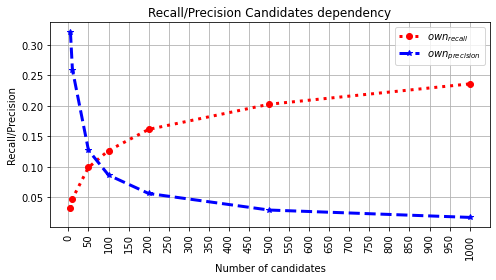

In [2823]:
num_candidates_list = [5, 10, 50, 100, 200, 500, 1000]
recalls_own = []
precisions_own = []

# result['own_loop'] = result['user_id'].apply(lambda x: rule(x, list_out, model='own', N=1000))

for k in num_candidates_list:
    result['own_loop'] = result['user_id'].apply(lambda x: rule(x, list_out, model='own', N=k))
    recalls_own.append(result.apply(lambda row: recall_at_k(row['own_loop'], row['actual'], k=k), axis=1).mean())
    precisions_own.append(result.apply(lambda row: precision_at_k(row['own_loop'], row['actual'], k=k), axis=1).mean())
result.drop('own_loop', axis=1, inplace=True)
    
plt.figure(figsize=(7,4))
plt.title('Recall/Precision Candidates dependency')
plt.plot(num_candidates_list, recalls_own, ls=':', color='red', lw=3, label='$own_{recall}$', marker='o')
plt.plot(num_candidates_list, precisions_own, ls='--', color='blue', lw=3, label='$own_{precision}$', marker='*')
plt.ylabel('Recall/Precision')
plt.xlabel('Number of candidates')
plt.grid()
plt.xticks(np.arange(0, 1001, 50), rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
result['als'] = result['user_id'].apply(lambda x: rule(x, list_out, model='als', N=5))
result['own'] = result['user_id'].apply(lambda x: rule(x, list_out, model='own', N=5))
# result['sim'] = result['user_id'].apply(lambda x: rule(x, list_out, model='similar_users', N=5))

In [68]:
for pred in calc_precision_at_k(result, 65):
    print(*pred, sep=': ')

als: 0.1673166202414113
own: 0.32191272051996284
sim: 0.09025069637883008


In [61]:
for pred in calc_recall(result, 65):
    print(*pred, sep=': ')

als: 0.07273533630056539
own: 0.10924299656193572
sim: 0.046356456556113076


In [69]:
for pred in calc_map_at_k(result):
    print(*pred, sep=': ')

als: 0.32758240482822654
own: 0.39668059424326835
sim: 0.18247975343031053


**Preparing**

In [70]:
class TfidfLDA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=5, learning_method='batch', max_features=10001, n_jobs=-1, random_state=42):
        self.n_components = n_components
        self.learning_method = learning_method
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.pipe = None
        
    def fit(self, X, y=None):
        self.pipe = make_pipeline(TfidfVectorizer(max_features=self.max_features),
                                  LatentDirichletAllocation(n_components=self.n_components,
                                                            learning_method=self.learning_method,
                                                            n_jobs=self.n_jobs,
                                                            random_state=self.random_state)).fit(X['item_id'].values)
        return self
        
    def transform(self, X):
        X_ = np.zeros((X.shape[0], self.n_components))
        for i in range(X_.shape[0]):
            X_[i, :] = self.pipe.transform(X.values[i])
        return pd.DataFrame(data=X_, columns=[f'topic_{i}' for i in range(self.n_components)], index=X.index)

In [71]:
id_to_userid = recommender.id_to_userid
id_to_itemid = recommender.id_to_itemid

userid_to_id = recommender.userid_to_id
itemid_to_id = recommender.itemid_to_id

user_factors = recommender.model.user_factors
item_factors = recommender.model.item_factors

In [72]:
# эмбеддинг юзера = среднее эмбеддингов купленниых им товаров / merge on user
emb_df = data_train[['user_id', 'item_id']].copy()
emb_df['item_id'] = emb_df['item_id'].apply(lambda x: np.array(item_factors[itemid_to_id[x], :]))
emb_df = emb_df.groupby('user_id')['item_id'].sum().reset_index()  # mean

# emb_df = pd.concat([emb_df.user_id, pd.DataFrame(data=emb_df.item_id.tolist(), columns=[f'emb_{i}' for i in range(20)])], axis=1)  #
# pca = PCA(n_components=5, random_state=42)
# X_embed = pca.fit_transform(emb_df.iloc[:, 1:])
# X_embed = pd.DataFrame(data=X_embed, columns=[f'emb_{i}' for i in range(X_embed.shape[1])])
# emb_df = pd.concat([emb_df.user_id, X_embed], axis=1)

# scalar value
emb_df['item_id'] = emb_df['item_id'].apply(lambda x: x.mean())
emb_df.rename(columns={'item_id': 'scalar_embedding'}, inplace=True)

In [73]:
# эмбеддинг товара - эмбеддинг юзера  # чем разница меньше, тем товар ближе к интересам пользователя / merge on user-item
diff_emb = data_train[['user_id', 'item_id']].copy()
diff_emb['diff_emb_scalar'] = diff_emb.apply(lambda row: (item_factors[itemid_to_id[row['item_id']]] - user_factors[userid_to_id[row['user_id']]]).mean(), axis=1)
diff_emb.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)

In [74]:
# merge on user-item
def get_item_score(user_id, item_ids):
    items_scores = recommender.own_recommender.recommend(userid=userid_to_id[user_id],
                                      user_items=csr_matrix(recommender.user_item_matrix).tocsr()[userid_to_id[user_id], :],
                                      N=len(item_ids)-1,
                                      filter_already_liked_items=False,
                                      filter_items=[itemid_to_id[999999]],
                                      recalculate_user=True)
    items_recs = [id_to_itemid[item] for item in items_scores[0]]
    indices = [items_recs.index(item) if item in items_recs else -1 for item in item_ids]
    result = np.array([items_scores[1][i] if i != -1 else 0 for i in indices])
    return result

it_it_df = data_train[['user_id', 'item_id']].copy()
for us in it_it_df.user_id.unique():
    it_it_df.loc[it_it_df.user_id == us, 'item_item'] = get_item_score(us, it_it_df.loc[it_it_df.user_id == us, 'item_id'])
it_it_df.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)

In [75]:
def get_dot(user_id, item_id):
    try:
        return user_factors[userid_to_id[user_id], :] @ item_factors[itemid_to_id[item_id], :].T
    except:
        return 0
    
def get_inv_rank(user_id):
    try:
        vector = user_factors[userid_to_id[user_id], :] @ item_factors.T
        vector = vector.flatten()
        return 1 / np.argmax(vector)
    except:
        return 0

**2nd level**

In [76]:
train_test = pd.concat([data_train, data_test])

In [77]:
df_candidates = pd.DataFrame(data=data_test['user_id'].unique().tolist())
df_candidates.columns = ['user_id']

# df_candidates['own'] = df_candidates['user_id'].apply(lambda x: rule(x, list_out, model='own', N=N_preds))
# df_candidates['als'] = df_candidates['user_id'].apply(lambda x: rule(x, list_out, model='als', N=N_preds))
# df_candidates['candidates'] = df_candidates['own'] + df_candidates['als']

df_candidates['candidates'] = df_candidates['user_id'].apply(lambda x: rule(x, list_out, model='own', N=N_preds))
df_candidates.head()

,user_id,candidates
0,843,"[1026118, 1081177, 9245108, 8205418, 1029743, ..."
1,2223,"[947858, 1047525, 5569845, 5568152, 870111, 91..."
2,278,"[1009719, 902172, 917384, 1067695, 895680, 113..."
3,468,"[5590465, 5591777, 1094308, 1044078, 1019637, ..."
4,1285,"[916122, 985999, 1128240, 1089568, 1042544, 11..."


In [78]:
df_candidates = pd.DataFrame({'user_id': df_candidates['user_id'].values.repeat(N_preds),
                              'item_id': np.concatenate(df_candidates['candidates'].values)})

df_train = data_test[['user_id', 'item_id']].copy()
df_train['target'] = 1

df_train = df_candidates.merge(df_train, on=['user_id', 'item_id'], how='left')
df_train.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)

df_train['target'].fillna(0, inplace=True)
df_train.head(2)

,user_id,item_id,target
0,843,1026118,1.0
1,843,1081177,0.0


In [79]:
df_train['target'].value_counts(normalize=True)

0.0    0.739412
1.0    0.260588
Name: target, dtype: float64

In [80]:
X_lda = train_test.groupby('user_id')['item_id'].unique().reset_index()
X_lda['item_id'] = X_lda['item_id'].apply(lambda x: ' '.join([str(i) for i in x]))
X_lda.head(2)

,user_id,item_id
0,1,856942 871570 940839 999999 1006184 1013167 10...
1,2,826597 888988 908649 911974 940947 999999 9882...


In [83]:
lda = TfidfLDA().fit_transform(pd.DataFrame(data=X_lda['item_id'].values.reshape(-1,1), 
                                            index=X_lda['user_id'].values, columns=['item_id'])).reset_index()
lda.rename(columns={'index': 'user_id'}, inplace=True)
lda.head(1)

,user_id,topic_0,topic_1,topic_2,topic_3,topic_4
0,1,0.012861,0.01286,0.012873,0.012859,0.948548


In [85]:
pca = PCA(n_components=5, random_state=42)
X_users = pca.fit_transform(user_factors)

X_users = pd.DataFrame(data=X_users).reset_index()
X_users.rename(columns={'index': 'user_id'}, inplace=True)
X_users['user_id'] = X_users['user_id'].apply(lambda x: id_to_userid[x])


pca = PCA(n_components=5, random_state=42)
X_items = pca.fit_transform(item_factors)

X_items = pd.DataFrame(data=X_items).reset_index()
X_items.rename(columns={'index': 'item_id'}, inplace=True)
X_items['item_id'] = X_items['item_id'].apply(lambda x: id_to_itemid[x])

In [86]:
# week_no	coupon_disc	coupon_match_disc / merge on item
disc_df = train_test.groupby('item_id')[['coupon_disc', 'coupon_match_disc']].mean().reset_index()

In [87]:
# first create new features in item_features! see 1st approach
df_train = df_train.merge(item_features, on='item_id', how='left')
df_train = df_train.merge(user_features, on='user_id', how='left')
df_train = df_train.merge(X_users, on='user_id', how='left')
df_train = df_train.merge(X_items, on='item_id', how='left')
df_train = df_train.merge(emb_df, on='user_id', how='left')  ## 
df_train = df_train.merge(diff_emb, on=['user_id', 'item_id'], how='left')  ## 
df_train = df_train.merge(it_it_df, on=['user_id', 'item_id'], how='left')  ##
df_train = df_train.merge(disc_df, on='item_id', how='left')  ## 
df_train = df_train.merge(lda, on='user_id', how='left')
df_train['factor'] = df_train.apply(lambda row: get_dot(row['user_id'], row['item_id']), axis=1)
df_train['inv_rank'] = df_train['user_id'].apply(lambda x: get_inv_rank(x))

In [88]:
df_train.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)
df_train.shape

(21463, 44)

In [90]:
train_test = train_test.merge(item_features[['item_id', 'department']], on='item_id', how='left')

df_train = create_multiple_features(df_train, train_val_lvl1=train_test)  
df_train = create_user_features(df_train, data_train=train_test) 
df_train = create_item_features(df_train, train_val_lvl1=train_test)
df_train = df_train.merge(get_new_features(train_test), on=['user_id', 'item_id'], how='left')

In [91]:
users_items = train_test.groupby('user_id')['item_id'].apply(list).reset_index()
users_items['item_id'] = users_items['item_id'].apply(lambda x: x[-5:])

In [92]:
def code_last_sales(x, df=users_items):
    last_sales = df.loc[df['user_id'] == x[0], 'item_id'].item()
    code = str()
    last_sales.reverse()
    for item in last_sales:
        code += '1' if item == x[1] else '0'
    return code

In [93]:
df_train['Last5sales'] = df_train[['user_id', 'item_id']].apply(code_last_sales, axis=1)

In [1149]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

In [94]:
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        df_train[column].fillna('unk', inplace=True)
    elif df_train[column].dtype in ['float64', 'float32']:
        df_train[column].fillna(0.0, inplace=True)

# number_cols = df_train.select_dtypes('number').columns.tolist()[2:]
# df_train[number_cols] = IterativeImputer(min_value=0.0, random_state=42).fit_transform(df_train[number_cols])

print(f'Length of train data: {df_train.shape[0]}')
df_train.dropna(inplace=True)
df_train = reduce_memory(df_train)
# df_train.info()

Length of train data: 21463


In [95]:
X, y = df_train.drop('target', axis=1), df_train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cat_cols = X.select_dtypes(include=['category']).columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

##### skip if not going to use built-in feature importances from lgb

In [1114]:
lgbm = LGBMClassifier(objective='binary', 
                     n_estimators=1500,
                     learning_rate=0.008,
                     max_depth=7, 
                     verbose=1,
                     categorical_column=cat_cols)

hist = lgbm.fit(X_train, y_train, 
                eval_set=[(X_train, y_train)],
                eval_metric=['logloss'],
                early_stopping_rounds=50,
                verbose=0)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3687, number of negative: 12603
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9692
[LightGBM] [Info] Number of data points in the train set: 16290, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226335 -> initscore=-1.229122
[LightGBM] [Info] Start training from score -1.229122


In [1116]:
print(f'ROC_AUC: ', f'{roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]):.4f}')
importances = lgbm.feature_importances_
indices = np.argsort(importances)[::-1]

lgbm_selected = X_train.columns[indices].tolist()[:30]
print(f'Selected by LGBM 30 features: {lgbm_selected}')

ROC_AUC:  0.9652
Selected by LGBM 30 features: ['sub_commodity_desc', 'median_sales_hour', 'mean_trans_time_by_user', 'commodity_desc', 'unique_bought_items', 'median_weekday', 'users_unique_departments', 'avg_price', 'user_id', 'user_freq', 'price', 'mean_visits_interval', 'avg_basket_department', 'mean_sales_value_per_basket', 'total_user_sales_value', 'avg_cheque', 'user_quantity_per_week', 'curr_size_of_product', 'n_stores_with_item', 'mean_trans_time_by_item', 'mean_n_items_basket', 'mean_n_item_categories_basket', 'n_transactions', 'max_n_items_basket', 'Last5sales', 'item_id', 'std_n_items_basket', 'total_item_sales_value', 'std_n_item_categories_basket', 'max_n_item_categories_basket']


In [103]:
lgbm_selected = ['sub_commodity_desc', 'avg_basket_department', 'unique_bought_items', 'user_id', 'mean_trans_time_by_user', 
                 'avg_interval', 'avg_price', 'avg_cheque', 'user_freq', 'mean_sales_value_per_basket', 
                 'users_unique_departments', 'total_user_sales_value', 'price', 'user_quantity_per_week', 'item_id', 
                 'n_stores_with_item', 'curr_size_of_product', 'commodity_desc', 'n_unique_stores_with_item', 'Last5sales', 
                 'total_item_sales_value', 'mean_trans_time_by_item', 'avg_num_purchases_week', 'item_freq', 
                 'total_quantity_value', 'manufacturer', 'income_desc', 'marital_status_code', 'mean_sales_value_category', 
                 'hh_comp_desc']

##### end of lgb

In [1596]:
feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=20)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Elimimated features: ['user_id', 'income_desc', 'household_size_desc', 'age_desc', 'kid_category_desc', 'manufacturer_freq', 'homeowner_desc', 'marital_status_code', 'std_n_item_categories_basket', 'curr_size_of_product', 'curr_size_of_product_freq', 'users_unique_departments', 'avg_num_purchases_week', 'item_quantity_per_week', 'manufacturer', 'hh_comp_desc', 'sub_commodity_desc_freq', 'department', 'commodity_category', 'mean_sales_value_category', 'total_quantity_value']


In [1597]:
drop = ['user_id', 'income_desc', 'household_size_desc', 'age_desc', 'kid_category_desc', 
        'homeowner_desc', 'std_n_item_categories_basket', 'curr_size_of_product', 
        'users_unique_departments', 'item_quantity_per_week',
        'hh_comp_desc', 'department', 'mean_sales_value_category', 'total_quantity_value']

X_train.drop(drop, axis=1, inplace=True)
X_valid.drop(drop, axis=1, inplace=True)

cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [1598]:
params_model = {
                'eval_metric': 'Logloss',
                'iterations': 1000,
                'silent': True,
                'one_hot_max_size': 2,  # 15
                'use_best_model': True,
                'early_stopping_rounds': 50,
                'allow_writing_files': False,
                'random_seed': 42,
                'auto_class_weights': 'SqrtBalanced',
                'bagging_temperature': 2.6004725626586676,
                'boosting_type': 'Plain',
                'colsample_bylevel': 0.9132686318360939,
                'depth': 12,
                'grow_policy': 'SymmetricTree',
                'l2_leaf_reg': 4.948252791068095,
                'learning_rate': 0.1206774907395364,
                'min_data_in_leaf': 240,
                'subsample': 0.8218973936992428
                }

In [1599]:
%%time
X_ = X.drop(drop, axis=1)
train_pool = Pool(X_, y, cat_features=cat_cols)
cat = CatBoostClassifier(**params_model).fit(train_pool, eval_set=valid_pool)  # train_pool overfit to perfectly predict only X_
print(f'ROC_AUC: ', f'{roc_auc_score(y, cat.predict_proba(X_)[:,1]):.4f}')

ROC_AUC:  1.0000
CPU times: total: 33min 41s
Wall time: 6min 5s


In [1600]:
df_predict = df_train.copy()
df_predict['proba_item_purchase'] = cat.predict_proba(X.drop(drop, axis=1))[:, 1]

In [1601]:
cold_users = test.loc[~test.user_id.isin(data_train.user_id), 'user_id'].unique()

In [1602]:
def rerank(user_id, N, out=cold_users):
    if user_id in df_predict.user_id:
        return df_predict[df_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(N).item_id.tolist()
    else:
        return rule(user_id, cold_users, model='own', N=5)

In [1603]:
test['pred'] = test['user_id'].apply(lambda x: rerank(x, 5))

condition = ((test.pred.isna()) | (test.pred.str.len() == 0))
test.loc[condition, 'pred'] = test.loc[condition, 'user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

In [1604]:
submission = transform_data_for_eval(test, rec_col='pred', user_col='user_id')
submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c gb-recsys-project -f submission.csv -m 'test1'  

Successfully submitted to GB RecSys Project



  0%|          | 0.00/73.3k [00:00<?, ?B/s]
100%|##########| 73.3k/73.3k [00:03<00:00, 21.5kB/s]


* private: 0.21730

In [1644]:
final['rerank'] = final['user_id'].apply(lambda x: rerank(x, 5))
cold_users = final.loc[~final.user_id.isin(data_train.user_id), 'user_id'].unique()

condition = ((final.rerank.isna()) | (final.rerank.str.len() == 0))
final.loc[condition, 'rerank'] = final.loc[condition, 'user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

for pred in calc_precision_at_k(final, 5):
    print(*pred, sep=': ')

rerank: 0.25389920424403184
lgbm_ranker: 0.2583554376657825


#### CatBoost Ranker for 2nd approach

In [2755]:
cat_cols = X.select_dtypes('category').columns.tolist()

train_pool = Pool(
                  data=X,
                  label=y,
                  cat_features=cat_cols,
                  group_id=X['user_id'].values
)

In [2766]:
def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRanker(iterations=1000, custom_metric='PrecisionAt:top=5', random_seed=42)
    summary = model.select_features(
        train_pool,
        eval_set=train_pool,
        features_for_select=list(range(X.shape[1])),
        num_features_to_select=40,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Exact,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Eliminated features:', summary['eliminated_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=16)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Eliminated features: ['factor', 'item_freq_per_basket', 'n_unique_stores_with_item', 'item_freq', 'n_stores_with_item', 'price', 'item_quantity_per_week', 'total_quantity_value', 'item_quantity_per_basket', '0_y', 'avg_num_purchases_week', 'total_item_sales_value', '4_y', 'manufacturer', 'commodity_desc', 'manufacturer_freq', 'commodity_desc_freq', 'brand', 'commodity_category', '2_y', 'sub_commodity_desc', 'curr_size_of_product_freq', 'item_id', 'sub_commodity_desc_freq', 'curr_size_of_product', 'mean_sales_value_category', '1_y']


In [2775]:
drop = ['factor', 'item_freq_per_basket', 'item_freq', 'n_stores_with_item', 'price', 
        'item_quantity_per_week', 'total_quantity_value', 'item_quantity_per_basket', '0_y', 'avg_num_purchases_week', 
        'total_item_sales_value', '4_y', 'manufacturer', 'manufacturer_freq', 'commodity_desc_freq', 
        'brand', 'commodity_category', '2_y', 'curr_size_of_product_freq', 'item_id', 
        'sub_commodity_desc_freq', '1_y']

X_ = X.drop(drop, axis=1).copy()
cat_cols = X_.select_dtypes('category').columns.tolist()

train = Pool(
             data=X_,
             label=y,
             cat_features=cat_cols,
             group_id=X['user_id'].values
            )

In [2776]:
advanced_parameters = {
                       'iterations': 2000,
                       'verbose': False,
                       'random_seed': 42,
                       'one_hot_max_size': 2,  
                       'early_stopping_rounds': 100,  
                       'allow_writing_files': False,
                       'grow_policy': 'Lossguide',
                       'boosting_type': 'Plain',
                       'use_best_model': True,
                       'depth': 9, 
                       'learning_rate': 0.18905265981777902, 
                       'l2_leaf_reg': 4.927368361978105, 
                       'subsample': 0.9, 
                       'colsample_bylevel': 0.8, 
                       # 'min_data_in_leaf': 55, 
                       # 'max_leaves': 35
}

In [2777]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=train):
    parameters = deepcopy(advanced_parameters)
    parameters['loss_function'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=False)
    
    return model

In [2778]:
%%time
model = fit_model('RMSE', {'custom_metric': ['PrecisionAt:top=5', 'RecallAt:top=5', 'MAP:top=5']})

CPU times: total: 14min 4s
Wall time: 6min 57s


In [2779]:
X_predict = X.copy()
X_predict['probabilities'] = catboost.CatBoost.predict(model, X_, prediction_type='Probability')[:, 1]

In [2780]:
roc_auc_score(y, X_predict['probabilities'])

0.9999760705472712

In [2773]:
test['cat_ranker'] = test['user_id'].apply(lambda x: rerank_cat(X_predict, x))
cold_users = test.loc[~test.user_id.isin(data_train.user_id), 'user_id'].unique()

condition = ((test.cat_ranker.isna()) | (test.cat_ranker.str.len() == 0))
test.loc[condition, 'cat_ranker'] = test.loc[condition, 'user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

In [2764]:
submission = transform_data_for_eval(test[['user_id', 'cat_ranker']], rec_col='cat_ranker', user_col='user_id')
submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c gb-recsys-project -f submission.csv -m 'test1' 

Successfully submitted to GB RecSys Project



  0%|          | 0.00/73.4k [00:00<?, ?B/s]
100%|##########| 73.4k/73.4k [00:02<00:00, 32.7kB/s]


* private: 0.21449 on Kaggle

In [2781]:
final['cat'] = final['user_id'].apply(lambda x: rerank_cat(X_predict, x))
cold_users = final.loc[~final.user_id.isin(data_train.user_id), 'user_id'].unique()

condition = ((final.cat.isna()) | (final.cat.str.len() == 0))
final.loc[condition, 'cat'] = final.loc[condition, 'user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

for pred in calc_precision_at_k(final, 5):
    print(*pred, sep=': ')

rerank: 0.25389920424403184
own: 0.2376657824933687
als: 0.11639257294429708
lgbm_ranker: 0.2653429282160626
cat: 0.25580901856763927


#### LGBMRanker for 1st / 2nd approach

In [99]:
# features retrieved from BestSet object
best_set = ['user_id', 'item_id', 'commodity_desc', 'sub_commodity_desc',
            'curr_size_of_product', 'manufacturer_freq', 'department_freq',
            'sub_commodity_desc_freq', 'curr_size_of_product_freq',
            'commodity_category', 'age_desc', 'income_desc', '0_x', '1_x', '2_x',
            '3_x', '4_x', '1_y', '2_y', '3_y', '4_y', 'scalar_embedding',
            'diff_emb_scalar', 'item_item', 'coupon_disc', 'factor', 'inv_rank',
            'total_item_sales_value', 'total_quantity_value', 'item_freq',
            'user_freq', 'total_user_sales_value', 'user_quantity_per_week',
            'avg_cheque', 'users_unique_departments', 'mean_trans_time_by_user',
            'mean_sales_value_per_basket', 'unique_bought_items',
            'avg_num_purchases_week', 'mean_trans_time_by_item',
            'n_stores_with_item', 'n_unique_stores_with_item', 'median_weekday',
            'mean_visits_interval', 'mean_n_items_basket', 'max_n_items_basket',
            'std_n_items_basket', 'mean_n_item_categories_basket',
            'max_n_item_categories_basket', 'Last5sales']

best_set = ['user_id', 'item_id', 'manufacturer', 'commodity_desc',
        'curr_size_of_product', 'manufacturer_freq', 'sub_commodity_desc_freq',
        'curr_size_of_product_freq', '3_x', '0_y', '1_y', '2_y', '3_y', '4_y',
        'scalar_embedding', 'item_item', 'coupon_disc', 'topic_0', 'factor',
        'total_item_sales_value', 'total_quantity_value',
        'user_quantity_per_week', 'avg_cheque', 'users_unique_departments',
        'mean_trans_time_by_user', 'mean_sales_value_per_basket',
        'unique_bought_items', 'avg_basket_department',
        'mean_sales_value_category', 'avg_price', 'avg_num_purchases_week',
        'price', 'mean_trans_time_by_item', 'n_stores_with_item',
        'n_unique_stores_with_item', 'median_sales_hour', 'median_weekday',
        'mean_visits_interval', 'n_transactions', 'max_n_items_basket',
        'std_n_items_basket', 'mean_n_item_categories_basket',
        'max_n_item_categories_basket', 'std_n_item_categories_basket',
        'Last5sales']

In [100]:
X_r = X[best_set].copy()
cat_cols = X_r.select_dtypes('category').columns.tolist()

# X_group = X.copy()
# X_group['group'] = np.arange(len(X))

# group = X_group[['user_id', 'group']].groupby('user_id', sort=False).max()['group'].values
# grs = np.concatenate((np.array([group[0]+1]), group[1:] - group[:-1]))

grs = X.groupby('user_id', sort=False).size().to_frame()[0].values

In [127]:
start_params = {
                'objective':'lambdarank',
                'boosting_type': 'gbdt',
                'n_estimators': 2000,
                'categorical_column': cat_cols,
                'random_state': 42,
                'is_unbalance': True,
                'n_jobs': -1,
}

In [128]:
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 9, 15),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 265),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 10, 260),
                    'min_child_samples': trial.suggest_int('min_child_samples', 20, 260),
                    'subsample_freq': trial.suggest_int('subsample_freq', 1, 20),
                    }
    param_trials.update(start_params)
    lgb_rn = LGBMRanker(**param_trials, silent=True)

    eval_h = lgb_rn.fit(X_r, y, group=grs,
                        eval_set=[(X_r, y)], eval_group=[grs], 
                        eval_metric=['ndcg'],
                        eval_at=[5, 10 ], 
                        early_stopping_rounds=50, 
                        verbose=0)
    
    rank_preds = lgb_rn.predict(X_r)
    ranker_prediction = X[['user_id', 'item_id']]
    ranker_prediction["pred"] = rank_preds
    
    ranker_prediction.drop_duplicates(inplace=True)
    ranker_prediction.sort_values(by="pred", inplace=True, ascending=False)
    
    ranked_res = ranker_prediction.groupby('user_id')['item_id'].unique().reset_index() 
    ranked_res = ranked_res.rename(columns={'item_id': 'lgbm_ranker'})  

    result = test1.groupby('user_id')['item_id'].unique().reset_index()
    result.columns = ['user_id', 'actual']
    cold_users = test1.loc[~test1.user_id.isin(data_train.user_id.tolist())].user_id.tolist()

    result = result.merge(ranked_res, on='user_id', how='left')
    result.loc[result.lgbm_ranker.isna(), 'lgbm_ranker'] = result.loc[result.lgbm_ranker.isna(), 'user_id'].\
        apply(lambda x: rule(x, cold_users, model='own', N=5))
    
    score = result.apply(lambda row: precision_at_k(row['lgbm_ranker'], row['actual'], k=5), axis=1).mean()
    
    return score

In [129]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=42), direction="maximize")
study.optimize(objective, n_trials=500, timeout=3000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

Number of completed trials: 500
Best trial
Best score: 0.26960212201591516
Best params
max_depth: 15
learning_rate: 0.025777021859048743
num_leaves: 217
subsample: 0.4425563225138566
colsample_bytree: 0.4537338498273604
max_bin: 159
min_child_samples: 108
subsample_freq: 18


In [131]:
lgb_params = {
              'objective':'lambdarank',
              'boosting_type': 'gbdt',
              'n_estimators': 2000,
              'categorical_column': cat_cols,
              'random_state': 42,
              'is_unbalance': True,
              'n_jobs': -1,
              #'max_depth': 14,
              #'learning_rate': 0.015104294331090354,
              #'num_leaves': 196,
              #'subsample': 0.9381810294606675,
              #'colsample_bytree': 0.7906492668877401,
              #'max_bin': 42,
              #'min_child_samples': 27,
              #'subsample_freq': 12
'max_depth': 15,
'learning_rate': 0.025777021859048743,
'num_leaves': 217,
'subsample': 0.4425563225138566,
'colsample_bytree': 0.4537338498273604,
'max_bin': 159,
'min_child_samples': 108,
'subsample_freq': 18
}

# experimentally it occurs optuna quality <= these params in most cases
lgb_params1 = {'objective': 'lambdarank',
              'boosting_type': 'gbdt',
              'learning_rate': 0.1,
              'n_estimators': 500,
              'max_depth': -1,
              'categorical_column': cat_cols,
              'random_state': 42,
              'is_unbalance': True,
              'n_jobs': -1,
             }

In [132]:
lgb_rn = LGBMRanker(**lgb_params, silent=True)

eval_h = lgb_rn.fit(X_r, 
                    y, 
                    group=grs,
                    eval_set=[(X_r, y)], 
                    eval_group=[grs], 
                    eval_metric=['ndcg', 'map'],
                    eval_at=[5, 10 ], 
                    early_stopping_rounds=100, 
                    verbose=0)

In [133]:
eval_h.evals_result_['training']['ndcg@5'][-1], eval_h.evals_result_['training']['map@5'][-1]

(1.0, 1.0)

In [134]:
rank_preds = lgb_rn.predict(X_r)

ranker_prediction = X[['user_id', 'item_id']]
ranker_prediction["pred"] = rank_preds

ranker_prediction = ranker_prediction.drop_duplicates()
ranker_prediction.sort_values(by="pred", inplace=True, ascending=False)

ranked_res = ranker_prediction.groupby('user_id')['item_id'].unique().reset_index() 
ranked_res = ranked_res.rename(columns={'item_id': 'lgbm_ranker'})  
ranked_res.head()

,user_id,lgbm_ranker
0,1,"[5577022, 856942, 940947, 8293439, 9297615, 86..."
1,2,"[1106523, 940947, 5569230, 911974, 1076580, 80..."
2,3,"[1092937, 1106523, 1050851, 854405, 1119761, 9..."
3,4,"[1075368, 883932, 998119, 1052294, 6391541, 89..."
4,6,"[1098844, 1024306, 5569230, 951412, 965267, 10..."


In [135]:
if 'lgbm_ranker' in test.columns:
    test.drop('lgbm_ranker', axis=1, inplace=True)

In [136]:
test = test.merge(ranked_res, on='user_id', how='left')
test.head()

,user_id,lgbm_ranker
0,1,"[5577022, 856942, 940947, 8293439, 9297615, 86..."
1,2,"[1106523, 940947, 5569230, 911974, 1076580, 80..."
2,3,"[1092937, 1106523, 1050851, 854405, 1119761, 9..."
3,6,"[1098844, 1024306, 5569230, 951412, 965267, 10..."
4,7,"[1122358, 1106523, 1126899, 9338009, 893018, 1..."


In [137]:
new = test[~test.user_id.isin(data_train.user_id.tolist())].user_id.tolist()

In [138]:
test.loc[test.lgbm_ranker.isna(), 'lgbm_ranker'] = test.loc[test.lgbm_ranker.isna(), 'user_id'].\
                                                                apply(lambda x: get_self_top_purchases(x))

In [139]:
submission = transform_data_for_eval(test[['user_id', 'lgbm_ranker']], rec_col='lgbm_ranker', user_col='user_id')
submission.to_csv('submission.csv', index=False)

In [140]:
!kaggle competitions submit -c gb-recsys-project -f submission.csv -m 'test1'  

Successfully submitted to GB RecSys Project



  0%|          | 0.00/134k [00:00<?, ?B/s]
100%|##########| 134k/134k [00:02<00:00, 57.3kB/s]


* **private: 0.24114 for 2nd approach on Kaggle**

##### test on local test dataframe

In [141]:
if 'lgbm_ranker' in final.columns.tolist():
    final.drop('lgbm_ranker', axis=1, inplace=True)
    
final = final.merge(ranked_res, on='user_id', how='left')
new = final[~final.user_id.isin(data_train.user_id.tolist())].user_id.tolist() 

# final['own'] = final['user_id'].apply(lambda x: rule(x, new, model='own', N=5))
# final['als'] = final['user_id'].apply(lambda x: rule(x, new, model='als', N=5))

final.loc[final.lgbm_ranker.isna(), 'lgbm_ranker'] = final.loc[final.lgbm_ranker.isna(), 'user_id'].\
                                                                apply(lambda x: get_self_top_purchases(x))
final.head(2)

,user_id,actual,lgbm_ranker
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[5577022, 856942, 940947, 8293439, 9297615, 86..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784...","[1106523, 940947, 5569230, 911974, 1076580, 80..."


In [142]:
for pred in calc_precision_at_k(final, 5):
    print(*pred, sep=': ')

lgbm_ranker: 0.2708866382373845


In [143]:
### WARM test ###
condition1 = test1.user_id.isin(data_test.user_id)
condition2 = test1.item_id.isin(data_test.item_id)
warm_test = test1[(condition1) & (condition2)][['user_id', 'item_id']]

warm_test = warm_test.groupby('user_id')['item_id'].unique().reset_index()
warm_test.rename(columns={'item_id': 'actual'}, inplace=True)
warm_test = warm_test.merge(ranked_res, on='user_id', how='left')

for pred in calc_precision_at_k(warm_test, 5):
    print(*pred, sep=': ')

lgbm_ranker: 0.2793704328274312


**Funny result with target leakage: Kaggle: precision@5 = 1.00**

In [2964]:
ftest = test1[['user_id', 'item_id']].copy()

ftest = ftest.merge(item_features, on='item_id', how='left')
ftest = ftest.merge(user_features, on='user_id', how='left')
ftest = ftest.merge(X_users, on='user_id', how='left')
ftest = ftest.merge(X_items, on='item_id', how='left')
ftest['factor'] = ftest.apply(lambda row: get_dot(row['user_id'], row['item_id']), axis=1)

#ftest = ftest.merge(item_features[['item_id', 'department']], on='item_id', how='left')

ftest = create_multiple_features(ftest, train_val_lvl1=train_test)  
ftest = create_user_features(ftest, data_train=train_test) 
ftest = create_item_features(ftest, train_val_lvl1=train_test)
ftest = ftest.merge(get_new_features(train_test), on=['user_id', 'item_id'], how='left')

users_items = ftest.groupby('user_id')['item_id'].apply(list).reset_index()
users_items['item_id'] = users_items['item_id'].apply(lambda x: x[-5:])

def code_last_sales(x, df=users_items):
    last_sales = df.loc[df['user_id'] == x[0], 'item_id'].item()
    code = str()
    last_sales.reverse()
    for item in last_sales:
        code += '1' if item == x[1] else '0'
    return code

ftest['Last5sales'] = ftest[['user_id', 'item_id']].apply(code_last_sales, axis=1)

for column in ftest.columns:
    if ftest[column].dtype == 'object':
        ftest[column].fillna('unk', inplace=True)
    elif ftest[column].dtype in ['float64', 'float32']:
        ftest[column].fillna(0.0, inplace=True)
        
print(f'Length of train data: {ftest.shape[0]}')
ftest.dropna(inplace=True)
ftest = reduce_memory(ftest)

X_test = ftest[best_set]

rank_preds_test = lgb_rn.predict(X_test)

ranker_prediction_test = X_test[['user_id', 'item_id']]
ranker_prediction_test["pred"] = rank_preds_test

ranker_prediction_test = ranker_prediction_test.drop_duplicates()
ranker_prediction_test.sort_values(by="pred", inplace=True, ascending=False)

ranked_res_test = ranker_prediction_test.groupby('user_id')['item_id'].unique().reset_index() 
ranked_res_test = ranked_res_test.rename(columns={'item_id': 'lgbm_ranker_test'})  

if 'lgbm_ranker_test' in test.columns:
    test.drop('lgbm_ranker_test', axis=1, inplace=True)
    
test = test.merge(ranked_res_test, on='user_id', how='left')

new = test[~test.user_id.isin(ftest.user_id.tolist())].user_id.tolist()

test.loc[test.lgbm_ranker_test.isna(), 'lgbm_ranker_test'] = test.loc[test.lgbm_ranker_test.isna(), 'user_id'].\
                                                                apply(lambda x: get_self_top_purchases(x))

submission = transform_data_for_eval(test[['user_id', 'lgbm_ranker_test']], rec_col='lgbm_ranker_test', user_col='user_id')
submission.to_csv('submission.csv', index=False)

!kaggle competitions submit -c gb-recsys-project -f submission.csv -m 'test1'  

Length of train data: 88734
Successfully submitted to GB RecSys Project



  0%|          | 0.00/603k [00:00<?, ?B/s]
 34%|###4      | 208k/603k [00:00<00:00, 1.31MB/s]
100%|##########| 603k/603k [00:04<00:00, 127kB/s] 


#### LightFM

[kaggle beautiful kernel](https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system)

In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset

import category_encoders as ce
from sklearn.pipeline import make_union

In [ ]:
def df_to_tuple_iterator(df):
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [ ]:
test_size_weeks = 5
N_preds = 10

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

print(f'Unique users in train set: {data_train.user_id.nunique()}, items: {data_train.item_id.nunique()}')
print(f'Unique users in valid set: {data_test.user_id.nunique()}, items: {data_test.item_id.nunique()}')
print(f'New users in test: {len(data_test[~data_test.user_id.isin(data_train.user_id)])}')

In [ ]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features=item_features)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


In [ ]:
data_train = data_train[data_train.item_id != 999999]

In [ ]:
dataset = Dataset()

In [ ]:
dataset.fit(users=data_train['user_id'].unique(), items=data_train['item_id'].unique(), )

In [ ]:
user_feats = []
for col in user_features.select_dtypes(exclude='number').columns:
    user_feats += user_features[col].unique().tolist()
user_feats = np.array(user_feats)
user_feats

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64', 'A', 'U', 'B',
       '35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K',
       'Homeowner', 'Unknown', 'Renter', 'Probable Renter',
       'Probable Owner', '2 Adults No Kids', '2 Adults Kids',
       'Single Female', 'Unknown', 'Single Male', '1 Adult Kids', '2',
       '3', '4', '1', '5+', 'None/Unknown', '1', '2', '3+'], dtype='<U16')

In [ ]:
item_feats = []
item_features.manufacturer = item_features.manufacturer.astype(np.object)

for col in item_features.select_dtypes(exclude='number').columns:
    item_feats += item_features[col].unique().tolist()
item_feats = np.array(item_feats)
item_feats

array(['2', '69', '16', ..., '6.3 IN', '35 LD', '2 LTR PET'], dtype='<U30')

In [ ]:
dataset.fit_partial(user_features=user_feats)

In [ ]:
dataset.fit_partial(item_features=item_feats)

In [ ]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('users_mapping len - ', len(lightfm_mapping['users_mapping']))
print('user_features_mapping len - ', len(lightfm_mapping['user_features_mapping']))
print('items_mapping len - ', len(lightfm_mapping['items_mapping']))
print('Users item_features_mapping len - ', len(lightfm_mapping['item_features_mapping']))

users_mapping len -  2467
user_features_mapping len -  2505
items_mapping len -  5000
Users item_features_mapping len -  18505


In [ ]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [ ]:
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(data_train[['user_id', 'item_id']]))

In [ ]:
user_features['features'] = user_features.iloc[:, :-1].astype(str).apply(lambda x: list(x), axis=1)

In [ ]:
known_users_filter = user_features['user_id'].isin(data_train['user_id'].unique())

train_user_features = dataset.build_user_features(
    df_to_tuple_list_iterator(
        user_features.loc[known_users_filter, ['user_id', 'features']]
    )
)
train_user_features

<2467x2505 sparse matrix of type '<class 'numpy.float32'>'
	with 8043 stored elements in Compressed Sparse Row format>

In [ ]:
item_features['features'] = item_features.iloc[:, 1:].astype(str).apply(lambda x: list(x), axis=1)

In [ ]:
known_items_filter = item_features['item_id'].isin(data_train['item_id'].unique())

train_items_features = dataset.build_item_features(
    df_to_tuple_list_iterator(
        item_features.loc[known_items_filter, ['item_id', 'features']]
    )
)
train_items_features

<5000x18505 sparse matrix of type '<class 'numpy.float32'>'
	with 34898 stored elements in Compressed Sparse Row format>

In [ ]:
lfm_model = LightFM(no_components=64, learning_rate=0.05, loss='warp', max_sampled=5, random_state=42)

In [ ]:
lfm_model.fit(train_mat,
              sample_weight=train_mat_weights,
              user_features=train_user_features,
              item_features=train_items_features,
              epochs=15, 
              num_threads=4) 

In [ ]:
all_cols = list(lightfm_mapping['items_mapping'].values())

In [ ]:
def predict_fm(user_id, n=5):
    try:
        pred = lfm_model.predict(lightfm_mapping['users_mapping'][user_id], 
                                 all_cols, 
                                 user_features=train_user_features,
                                 item_features=train_items_features,
                                 num_threads=4)
    except:
        return popularity_recommendation(data_train, n=n)
    top_cols = np.argpartition(pred, -np.arange(n))[-n:][::-1]
    pred = [lightfm_mapping['items_inv_mapping'].get(top) for top in top_cols]
    return pred

In [ ]:
new_users = test.loc[~test.user_id.isin(data_train.user_id), 'user_id'].values
new_users

array([  62,   75,  650,  954, 1043, 1105, 1636, 1876, 1987, 2120, 2259,
       2325, 2404])

In [ ]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

result['pred'] = result['user_id'].apply(lambda x: predict_fm(x))

for pred in calc_precision_at_k(result, 5):
    print(*pred, sep=': ')

for pred in calc_map_at_k(result):
    print(*pred, sep=': ')

pred: 12.095984329089129
pred: 25.02360158885624


In [ ]:
test['pred'] = test['user_id'].apply(lambda x: predict_fm(x))

In [ ]:
test.head()

,user_id,pred
0,1,"[999104, 940947, 1127831, 872137, 866211]"
1,2,"[5569230, 916122, 1029743, 844179, 1127831]"
2,3,"[1044078, 844179, 1029743, 1106523, 907631]"
3,6,"[854852, 1026118, 866211, 878996, 1081177]"
4,7,"[1029743, 916122, 1106523, 899624, 844179]"


In [ ]:
submission = transform_data_for_eval(test[['user_id', 'pred']], rec_col='pred', user_col='user_id')
submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c gb-recsys-project -f submission.csv -m 'test1'

100% 71.3k/71.3k [00:02<00:00, 26.4kB/s]
Successfully submitted to GB RecSys Project